<a href="https://colab.research.google.com/github/88FaHaD/Deep-learning/blob/main/Transfer_learning_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning


Transfer learning is a machine learning technique where a model trained on one task is reused and fine-tuned for a related task, leveraging pre-learned features to save time and improve performance.

# Feaure extraction
Feature extraction is using a pre-trained model to pull out useful patterns or information from data, which can then be used for another task. For example, using a CNN to get image features for a simpler model.

In [33]:
import tensorflow as tf

In [34]:
import zipfile

# download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# unzip
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2025-01-23 03:55:40--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 142.250.141.207, 74.125.137.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.2’

10_food_classes_10_ 100%[===================>] 160.74M   199MB/s    in 0.8s    

2025-01-23 03:55:41 (199 MB/s) - ‘10_food_classes_10_percent.zip.2’ saved [168546183/168546183]



In [35]:
import os
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE=(224,224)
BATCH_SIZE=32

train_dir="10_food_classes_10_percent/train/"
test_dir="10_food_classes_10_percent/test/"

# data laoding adn preprocessing

In [37]:
train_datagen=ImageDataGenerator(rescale=1/255.)
test_datagen=ImageDataGenerator(rescale=1/255.)

train_data=train_datagen.flow_from_directory(train_dir,target_size=IMAGE_SHAPE,batch_size=BATCH_SIZE,class_mode="categorical")
test_data=test_datagen.flow_from_directory(test_dir,target_size=IMAGE_SHAPE,batch_size=BATCH_SIZE)

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


# Callbacks
Callbacks are functions or objects used during training to perform actions at specific stages (e.g., after each epoch). Examples include saving the best model, early stopping, or adjusting the learning rate. They help monitor and improve training efficiency.

## popular ones are
1. tensorboard callback
2. modelcheckoint callback
3. earlystoping callback

# Tensorboard callback
The TensorBoard callback logs training metrics (e.g., loss, accuracy) and visualizes them in TensorBoard for real-time monitoring and analysis. Use it during model training to track performance, debug, and optimize hyperparameters.

TensorBoard is primarily used for tracking and visualizing model training metrics like loss, accuracy, and other custom metrics in real-time.

In [38]:
# Create tensorboard callback
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir=dir_name+"/"+experiment_name+"/"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# Load a Pre-trained Model for Feature Extraction

In [39]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers

# Load MobileNetV2 as the base model
base_model = MobileNetV2(
    input_shape=IMAGE_SHAPE + (3,),  # Input shape for the model
    include_top=False,  # Exclude the top classification layer
    weights="imagenet"  # Use pre-trained weights
)

# Freeze the base model to prevent training
base_model.trainable = False

# Print the base model summary
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

# Add a Custom Classifier
Add a custom classifier on top of the base model for your specific task.

In [40]:
# Create the model
mobilenetv2model = tf.keras.Sequential([
    base_model,  # Base model for feature extraction
    layers.GlobalAveragePooling2D(),  # Pooling layer to reduce dimensions
    layers.Dense(256, activation="relu"),  # Dense layer with ReLU activation
    layers.Dropout(0.5),  # Dropout layer to prevent overfitting
    layers.Dense(train_data.num_classes, activation="softmax")  # Output layer
])

# Compile the model
mobilenetv2model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Print the model summary
mobilenetv2model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,588,490 (9.87 MB)

 Trainable params: 330,506 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [41]:
# Check the number of images in the training and test datasets
num_train_samples = len(train_data.filepaths)
num_test_samples = len(test_data.filepaths)

print(f"Number of training samples: {num_train_samples}")
print(f"Number of test samples: {num_test_samples}")

# Calculate steps_per_epoch and validation_steps
steps_per_epoch = num_train_samples // BATCH_SIZE
validation_steps = num_test_samples // BATCH_SIZE

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

Number of training samples: 750
Number of test samples: 2500
Steps per epoch: 23
Validation steps: 78


In [42]:
# Train the model with corrected steps
history = mobilenetv2model.fit(
    train_data,
    epochs=5,  # Number of epochs for initial training
    steps_per_epoch=steps_per_epoch,  # Corrected steps_per_epoch
    validation_data=test_data,  # Validation data
    validation_steps=validation_steps,  # Corrected validation_steps
    callbacks=[create_tensorboard_callback("transfer_learning_logs", "mobilenetv2_feature_extraction")]
)

Saving TensorBoard log files to: transfer_learning_logs/mobilenetv2_feature_extraction/20250123-035546
Epoch 1/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 25s 630ms/step - accuracy: 0.2272 - loss: 2.3715 - val_accuracy: 0.6859 - val_loss: 0.9935
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 525ms/step - accuracy: 0.7188 - loss: 0.9490 - val_accuracy: 0.7500 - val_loss: 1.6020
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 351ms/step - accuracy: 0.6886 - loss: 1.0065 - val_accuracy: 0.7628 - val_loss: 0.7160
Epoch 4/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6562 - loss: 0.9277 - val_accuracy: 0.7500 - val_loss: 0.4750
Epoch 5/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 334ms/step - accuracy: 0.7726 - loss: 0.6962 - val_accuracy: 0.7656 - val_loss: 0.6950


In [43]:
test_loss, test_accuracy = mobilenetv2model.evaluate(test_data)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - accuracy: 0.7507 - loss: 0.7293
Test Loss: 0.6943668723106384
Test Accuracy: 0.765999972820282


In [44]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
    """
    Plots separate loss and accuracy curves for training and validation metrics.

    Args:
        history: A TensorFlow History object containing training/validation metrics.
    """
    # Extract metrics from the history object
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))  # Number of epochs

    # Plot loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="Training Loss")
    plt.plot(epochs, val_loss, label="Validation Loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="Training Accuracy")
    plt.plot(epochs, val_accuracy, label="Validation Accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

    plt.show()

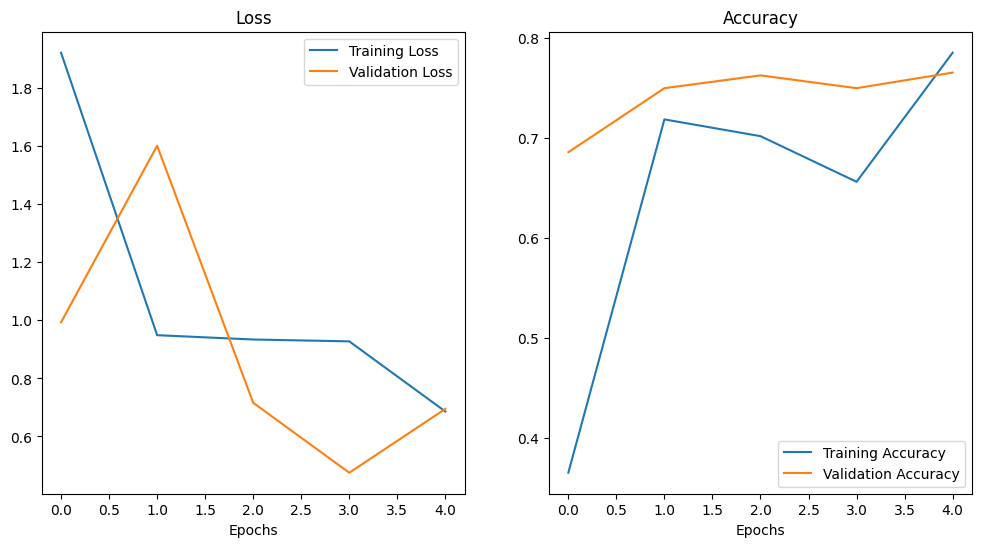

In [45]:
plot_loss_curves(history)

# Visualizing the predctions

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import random

def predict_random_image(model, data_generator, class_names):
    """
    Takes a random image from the dataset, makes a prediction, and displays the result.

    Args:
        model: The trained model.
        data_generator: The data generator (e.g., train_data or test_data).
        class_names: A list of class names corresponding to the dataset.
    """
    # Get a random batch of images and labels from the data generator
    images, labels = next(data_generator)

    # Select a random image from the batch
    random_index = random.randint(0, len(images) - 1)
    random_image = images[random_index]
    true_label = labels[random_index]

    # Expand dimensions to match the model's input shape (batch size of 1)
    random_image = np.expand_dims(random_image, axis=0)

    # Make a prediction
    predictions = model.predict(random_image)
    predicted_class_index = np.argmax(predictions)
    predicted_class_name = class_names[predicted_class_index]

    # Get the true class name
    true_class_index = np.argmax(true_label)
    true_class_name = class_names[true_class_index]

    # Display the image and prediction
    plt.imshow(images[random_index])
    plt.title(f"True: {true_class_name}\nPredicted: {predicted_class_name}")
    plt.axis("off")
    plt.show()

    # Print the prediction probabilities
    print("Prediction Probabilities:")
    for i, prob in enumerate(predictions[0]):
        print(f"{class_names[i]}: {prob:.4f}")

In [64]:
class_names = list(train_data.class_indices.keys())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


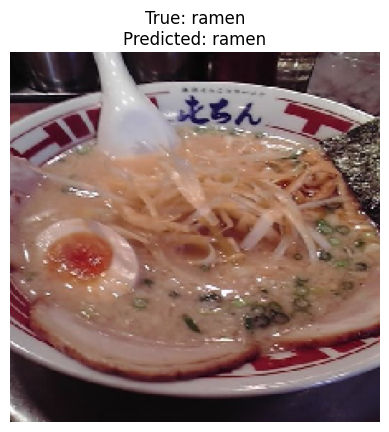

Prediction Probabilities:
chicken_curry: 0.0422
chicken_wings: 0.0021
fried_rice: 0.0059
grilled_salmon: 0.0041
hamburger: 0.0270
ice_cream: 0.0245
pizza: 0.0029
ramen: 0.8724
steak: 0.0182
sushi: 0.0006


In [71]:
predict_random_image(mobilenetv2model, test_data, class_names)